International Monetary Fund API with Python
=====

## U.K., U.S., and German CPI inflation example

*January 23, 2018*<br>
*@bd_econ*

-----

IMF API Documentation is [here](http://datahelp.imf.org/knowledgebase/articles/667681-json-restful-web-service)

In [1]:
# Python 3.6
import requests
import pandas as pd

#### Parameters/ Settings

In [2]:
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
param = [('dataset', 'IFS'),
         ('freq', 'M'),
         ('country', 'GB+DE+US'),
         ('series', 'PCPI_IX'),
         ('start', '?startPeriod=1991')]
series = '.'.join([i[1] for i in param[1:4]])

key = f'CompactData/{param[0][1]}/{series}{param[-1][1]}'

#### Make request and convert to annual percent change

In [3]:
r = requests.get(f'{url}{key}').json()
df = pd.DataFrame()
for s in r['CompactData']['DataSet']['Series']:
    dt = [pd.to_datetime(i['@TIME_PERIOD']) for i in s['Obs']]
    val = [float(i['@OBS_VALUE']) for i in s['Obs']]
    df[s['@REF_AREA']] = (pd.Series(val, index=dt).pct_change(12) * 100).dropna()

#### Plot results

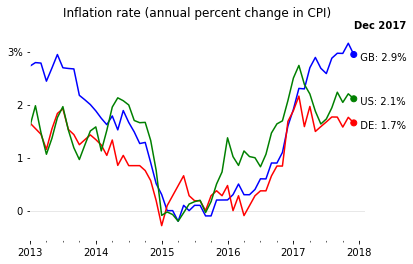

In [4]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('axes',edgecolor='w')

ax = df.plot(title='Inflation rate (annual percent change in CPI)', 
             color=['blue', 'red', 'green'], legend=False)
ax = plt.axhline(0, color='lightgray', lw=0.5, zorder=-1)
ax = plt.scatter([df.index[-1]] * 3, df.iloc[-1].values, 
                 color=['blue', 'red', 'green'])
for i, txt in enumerate(df.iloc[-1].values):
    ax = plt.annotate(f'  {df.iloc[-1].index[i]}: {txt:.2}%', 
                      (df.index[-1], txt-0.1))
ax = plt.annotate(f'{df.index[-1]:%b %Y}', (df.index[-1], df.iloc[-1].max() + 0.5), 
                  fontweight='bold')
ax = plt.xlim(pd.to_datetime('2013-01-01'), pd.to_datetime('2018-02-01'))
ax = plt.ylim(-0.55,3.55)
ax = plt.yticks([3, 2, 1, 0], ['3%', '2', '1', '0'])

------

## Metadata and param lookup examples

#### Find available series by search term "trade"

In [5]:
key = 'Dataflow'  # Method with series information
t = 'Trade'  # Term to find in series names
sl = requests.get(f'{url}{key}').json()['Structure']['Dataflows']['Dataflow']
# Print list of series containing text t
for s in (s for s in sl if t in s['Name']['#text']): 
    code = s['KeyFamilyRef']['KeyFamilyID']
    print(f"{s['Name']['#text']}: {code}")

Direction of Trade Statistics (DOTS): DOT
International Trade in Services: ITS
Direction of Trade Statistics (DOTS), 2017 Q1: DOT_2017Q1
Prices, Production, Labor and Trade (PPLT): PPLT
Direction of Trade Statistics (DOTS), 2017 Q2: DOT_2017Q2


#### Print the dimensions for a given series, "DOT"

In [6]:
key = 'DataStructure/DOT'  # Method / series
dl = requests.get(f'{url}{key}').json()\
    ['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension']
for n, d in enumerate(dl):
    print(f"Dimension {n+1}: {d['@codelist']}")

Dimension 1: CL_FREQ
Dimension 2: CL_AREA_DOT
Dimension 3: CL_INDICATOR_DOT
Dimension 4: CL_COUNTERPART_AREA_DOT


#### See what values are acceptable for dimension "CL_INDICATOR_DOT"

In [7]:
# Example: codes for dimension 3
key = f"CodeList/{dl[2]['@codelist']}"
cl = requests.get(f'{url}{key}').json()['Structure']['CodeLists']['CodeList']['Code']
for c in cl:
    print(f"{c['Description']['#text']}: {c['@value']}")

Goods, Value of Exports, Free on board (FOB), US Dollars: TXG_FOB_USD
Goods, Value of Imports, Cost, Insurance, Freight (CIF), US Dollars: TMG_CIF_USD
Goods, Value of Imports, Free on board (FOB), US Dollars: TMG_FOB_USD
Goods, Value of Trade Balance, US Dollars: TBG_USD


#### Bad example for how to get metadata

Probably better to just print the text, m, and read it.

In [8]:
key = 'GenericMetadata/IFS/M.GB.PMP_IX'
m = requests.get(f'{url}{key}').json()['GenericMetadata']['MetadataSet']['AttributeValueSet']
country = m[1]['ReportedAttribute'][1]['ReportedAttribute'][3]['Value']['#text']
indicator = m[2]['ReportedAttribute'][1]['ReportedAttribute'][3]['Value']['#text']
print(f'Country: {country}; Indicator: {indicator}')

Country: United Kingdom; Indicator: Prices, Import Price Index, All Commodities, Index


In [10]:
m

{'ReportedAttribute': [{'@conceptID': 'OBS_IFS_KEY',
   'ReportedAttribute': {'@conceptID': 'FREQ',
    'Value': {'#text': '4', '@xml:lang': 'en'}}},
  {'@conceptID': 'FREQ',
   'ReportedAttribute': [{'@conceptID': 'FREQ_NAME',
     'Value': {'#text': 'Monthly', '@xml:lang': 'en'}},
    {'@conceptID': 'FREQ_ID', 'Value': {'#text': 'MONTH', '@xml:lang': 'en'}},
    {'@conceptID': 'FREQ_MNEMO',
     'Value': {'#text': 'M', '@xml:lang': 'en'}}]}],
 'TargetRef': 'DATA_STRUCTURE_DEFINITION',
 'TargetValues': {'ComponentValue': {'#text': 'IFS',
   '@component': 'DSD',
   '@object': 'KeyFamily'}}}